# Mesa agent based model of farm/herd pathogen strain spread

* A Practical Introduction to Mechanistic Modeling of Disease Transmission in Veterinary Science. Kirkeby et al. Front. Vet. Sci., 26 January 2021 [link](https://www.frontiersin.org/articles/10.3389/fvets.2020.546651/full)
* Individual-based model for the control of Bovine Viral Diarrhea spread in livestock trade networks. Bassett et al. [link](https://doi.org/10.1016/j.jtbi.2021.110820)
* Representing Tuberculosis Transmission with Complex Contagion: An Agent-Based Simulation Modeling Approach. Zwick et al. Medical Decision Making April 27, 2021. [link](https://doi.org/10.1177/0272989X21100784)

In [2]:
import sys,os,random,time,string
import subprocess
import math
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('max_colwidth', 200)
import pylab as plt
import seaborn as sns
import geopandas as gpd
import networkx as nx
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO, AlignIO
from IPython.display import display, HTML
import toyplot,toytree
import json

In [3]:
from btbabm import models
from btbabm import utils

## Parameters

* mean_stay_time - mean time in a herd
* mean_inf_time - mean infection time
* cctrans - cow-cow transmission prob
* infected_start - time step infection starts
* seq_length - sequence length
* herd_class - type of herd

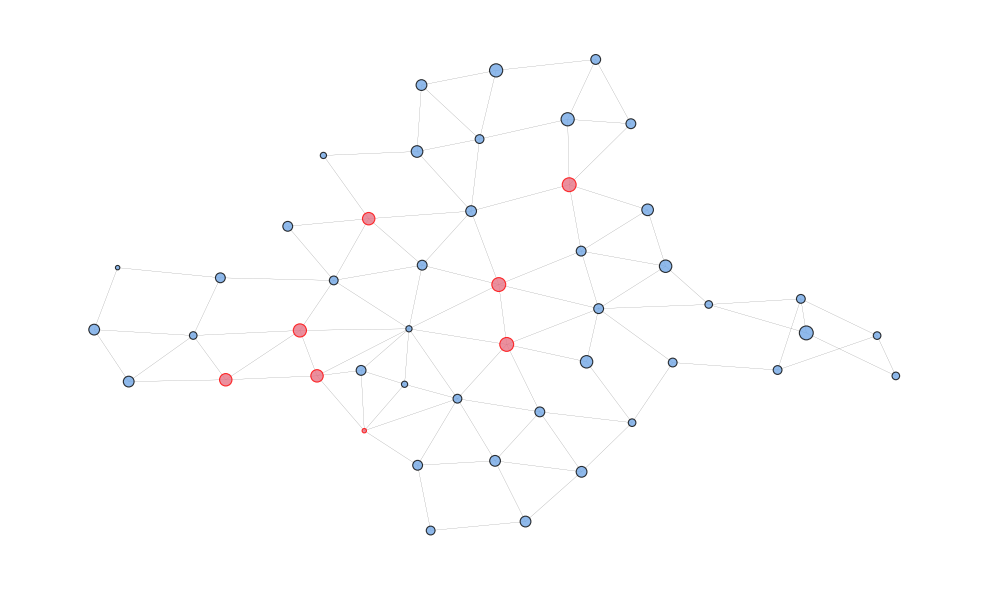

In [253]:
model = models.FarmPathogenModel(F=40,C=200,S=8)
fig,ax=plt.subplots(1,1,figsize=(10,6))
utils.plot_grid(model,ax=ax,colorby='loc_type')

## land parcels to network graph

- generate land parcels and then get network from it
- edges where parcels are close by
- weights for node distance

/home/farrell/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


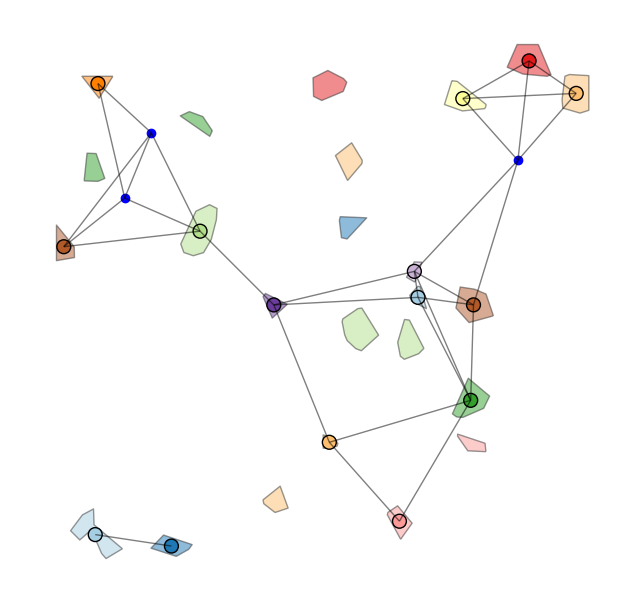

In [264]:
reload(utils)
farms = utils.generate_land_parcels(500,20,frac=.05,shuffle=0.14,seed=10)
fig,ax=plt.subplots(1,1,figsize=(8,8))
#ax=ax.flat
farms.plot(column='herd',ec='.2',cmap='Paired',alpha=0.5,ax=ax)#,legend=True)
#add setts
setts = utils.random_geodataframe(3)
setts['loc_type']='sett'
setts.plot(color='blue',ax=ax)
ax.axis('off')

#get cents
larg = farms.geometry.apply(utils.get_largest_poly)
cent = gpd.GeoDataFrame(data=farms.copy(),geometry=larg.geometry.centroid)
cent.plot(column='herd',cmap='Paired',ec='black',s=100,ax=ax)
cent['loc_type']='cow'

#make network graph
gdf = pd.concat([cent,setts]).reset_index(drop=True)
#print (gdf)
#G,pos = utils.delaunay_pysal(gdf, attrs=['loc_type','herd'])
G,pos = utils.geodataframe_to_graph(gdf, d=300, attrs=['loc_type','herd'])

cont = utils.contiguous_parcels(farms)
#print (cont)
#add egdes where nodes have contiguous parcels
for n in G.nodes:
    #print (n,G.nodes[n])   
    #print(nx.get_node_attributes(G,n))
    if n not in cont: 
        continue
    for j in cont[n]:
        if j!=n:
            G.add_edge(n,j)
#add more egdes for setts if near any other parcels

nx.draw(G,pos,node_size=0,alpha=0.5,ax=ax)
#nx.draw(G,pos,ax=ax[1])
#farms.fragments.hist(grid=False,ax=ax[2])

## test model

model with 400 farms, 3 setts and 2024 animals
CC rate:0.01 BC rate:0.1


/home/farrell/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


<AxesSubplot: xlabel='Step'>

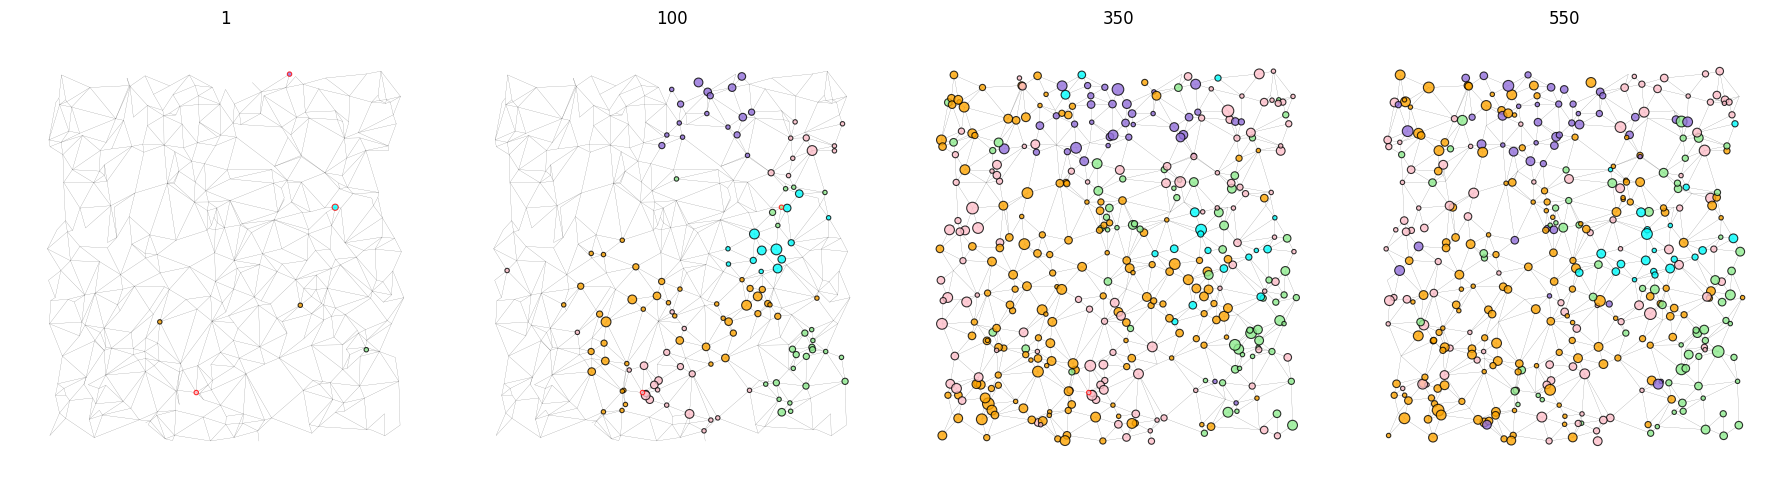

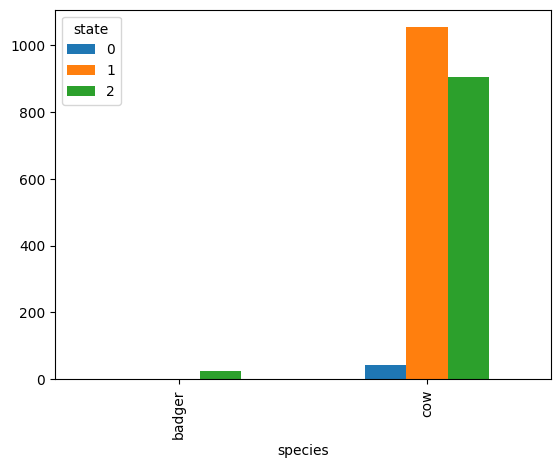

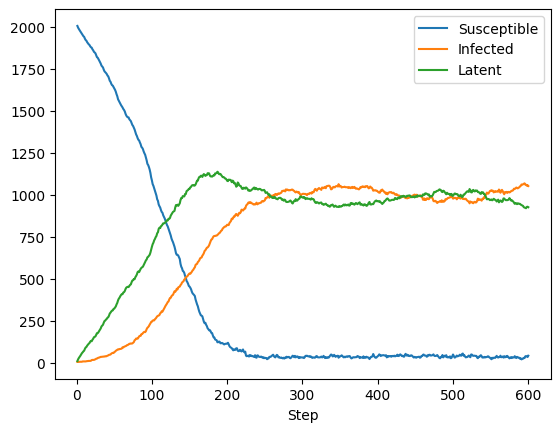

In [265]:
reload(utils)
reload(models)

model = models.FarmPathogenModel(F=400,S=3,C=2000,mean_inf_time=100,mean_stay_time=300,mean_latency_time=120,infected_start=2,allow_moves=True,
                       cctrans=0.01,bctrans=0.1,seq_length=100,graph_type='default',graph_seed=7)
print (model)

fig,ax=plt.subplots(1,4,figsize=(18,5))
axs=ax.flat
st=time.time()
i=0

for s in range(600):
    if s in [1,100,350,550]:
        utils.plot_grid(model,ax=axs[i],pos=model.pos,colorby='strain',ns='num_infected')
        axs[i].set_title(s)
        i+=1
    model.step()
#model.get_moves()
df=model.get_infected_data()
#print (df.species.value_counts())
#model.get_herds_data()
#fig=plot_herds_data(model)
#fig,ax=plt.subplots(1,2,figsize=(15,4))
fig = utils.plot_by_species(model)
df=model.get_column_data()
df.plot()
#print (time.time()-st)

## explore parameters

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(15,7))
axs=ax.flat
i=0
#for cc in np.arange(0.001,0.02,0.005):
for val in range(1,300,50):
    ax=axs[i]
    model = models.FarmPathogenModel(F=40,C=1200,S=5,mean_inf_time=val,mean_stay_time=360,mean_latency_time=150,
                           cctrans=0.01,bctrans=0.01,seq_length=100)                       
    for s in range(250):      
        model.step()
    df=model.get_infected_data()
    data = model.get_column_data()
    #print (data)
    i+=1
    data.plot(ax=ax)
    ax.set_title(val)
plt.tight_layout()


## dashboard

In [145]:
import panel as pn
import panel.widgets as pnw
pn.extension('tabulator', css_files=[pn.io.resources.CSS_URLS['font-awesome']])

In [254]:
reload(utils)
reload(models)

def dashboard():
    
    def run_model(farms, animals, setts, cctrans, bctrans, staytime, inftime, latencytime, infstart, steps, delay, graph_type, graph_seed, refresh):

        def callback(x):
            str_pane.value += str(x)+'\n'

        model = models.FarmPathogenModel(farms, animals, setts, staytime, inftime, latencytime, cctrans, bctrans, infstart, False, 100, 
                              graph_type, graph_seed=graph_seed,
                              callback=callback)
        str_pane.value = ''
        callback(model)
        #fig1,ax1 = plt.subplots(1,1,figsize=(15,10))
        #grid_pane.object = fig1    
        fig2,ax2 = plt.subplots(1,1,figsize=(8,6))    
        plot_pane1.object = fig2
        fig3,ax3 = plt.subplots(1,1,figsize=(8,6))   
        plot_pane2.object = fig3
        progress.max=steps
        progress.value = 0 
          
        showsteps = list(range(1,steps+1,refresh))        
        #step through the model and plot at each step
        for i in range(1,steps+1):
            model.step()            
            plt.close()
            if i in showsteps:
                #ax1.clear()
                ns=nodesize_input.value
                y=model.year
                mov=len(model.get_moves())
                deaths=model.deaths
                total = len(model.get_animals())
                col = colorby_input.value
                text='day=%s year=%s moves=%s deaths=%s animals=%s' %(i,y,mov,deaths,total)
                #utils.plot_grid(model,ax=ax1,pos=model.pos,
                #          title=text, colorby=col, cmap=cmap_input.value,
                #          ns=ns, with_labels=labels_input.value)    
                p=utils.plot_grid_bokeh(model, title=text)
                grid_pane.object = p
                grid_pane.param.trigger('object')
                
                ax2.clear()        
                #s = model.circulating_strains()
                #d=model.get_infected_data()
                #df_pane.value = d
                hd = model.get_herds_data()
                df2_pane.value = hd
                #fig2 = utils.plot_inf_data(model)
                fig2 = utils.plot_by_species(model)
                plot_pane1.object = fig2                 
                plot_pane1.param.trigger('object')
                df = model.get_column_data()
                ax3.clear()
                df.plot(ax=ax3)
                ax3.set_xlim(0,steps)
                plot_pane2.param.trigger('object')
                html=html_tree(model)
                tree_pane.object = html
                out = model.G.nodes
                
            progress.value += 1
            time.sleep(delay)
        plt.clf()

    def html_tree(model):
        result = model.make_phylogeny(removed=True,redundant=False)
        if result==None:
            return '<p>no tree</p>'
        cl = model.get_clades('tree.newick')    
        idf = model.get_animal_data(removed=True)
        x=idf.merge(cl,left_on='id',right_on='SequenceName')
        x=x.set_index('SequenceName')
        x.index = x.index.map(str)
        tre=toytree.tree('tree.newick')
        col='strain'
        canvas = utils.draw_tree('tree.newick',x,col,tip_labels=False,width=500)
        toyplot.html.render(canvas, "temp.html")
        with open('temp.html', 'r') as f:
            html = f.read()
        return html
      
    def set_stop(event):
        global stop
        stop = True
        print ('STOP')
  
    graph_types = ['default','watts_strogatz','erdos_renyi','barabasi_albert','powerlaw_cluster','random_geometric']
    farm_types = ['mixed','beef','dairy','suckler']
    cmaps = ['Blues','Reds','Greens','RdBu','coolwarm','summer','winter','icefire','hot','viridis']
    #grid_pane = pn.pane.Matplotlib(plt.Figure(),tight=True,width=900,height=620)
    grid_pane = pn.pane.Bokeh(width=800)
    plot_pane1 = pn.pane.Matplotlib(plt.Figure(),height=300)
    plot_pane2 = pn.pane.Matplotlib(plt.Figure(),height=300)
    tree_pane = pn.pane.HTML()
    str_pane = pnw.TextAreaInput(disabled=True,height=600,width=400) 
    df_pane = pnw.Tabulator(show_index=False,disabled=True,height=600)
    df2_pane = pnw.Tabulator(show_index=False,disabled=True,height=600)
    
    w=140
    colorby = ['num_infected','perc_infected','herd_size','loc_type','herd_class','strain']
    go_btn = pnw.Button(name='run',width=w,button_type='success')
    stop_btn = pnw.Button(name='stop',width=w,button_type='danger')
    farms_input = pnw.IntSlider(name='farms',value=20,start=5,end=1000,step=1,width=w)
    animals_input = pnw.IntSlider(name='cows',value=400,start=10,end=5000,step=10,width=w)
    setts_input = pnw.IntSlider(name='setts',value=5,start=1,end=100,step=1,width=w)
    farmtypes_input = pnw.Select(name='farm types',options=farm_types,width=w)
    cctrans_input = pnw.FloatSlider(name='CC trans',value=1,step=.1,start=0,end=5,width=w)
    bctrans_input = pnw.FloatSlider(name='BC trans',value=1,step=.1,start=0,end=5,width=w)
    staytime_input = pnw.FloatSlider(name='mean stay time',value=100,step=1,start=5,end=1000,width=w)
    inftime_input = pnw.FloatSlider(name='mean inf. time',value=60,step=1,start=5,end=600,width=w)
    latencytime_input = pnw.FloatSlider(name='mean latency time',value=100,step=1,start=10,end=600,width=w)
    infstart_input = pnw.FloatSlider(name='start infected',value=5,step=1,start=1,end=500,width=w)
    steps_input = pnw.IntSlider(name='steps',value=10,start=1,end=2000,width=w)
    refresh_input = pnw.IntSlider(name='refresh rate',value=1,start=1,end=100,width=w)
    delay_input = pnw.FloatSlider(name='step delay',value=0,start=0,end=3,step=.2,width=w)
    graph_input = pnw.Select(name='graph type',options=graph_types,width=w)
    graph_seed_input = pnw.IntInput(name='graph seed',value=10,width=w)
    #seed_input = pnw.Select(name='graph seed',options=['random'],width=w)
    colorby_input = pnw.Select(name='color by',options=colorby,width=w)
    colorby_input.value = 'strain'
    cmap_input = pnw.Select(name='colormap',options=cmaps,width=w)
    nodesize_input = pnw.Select(name='node size',value='herd_size',options=colorby[:3],width=w)
    labels_input = pnw.Checkbox(name='node labels',value=False,width=w)
    progress = pn.indicators.Progress(name='Progress', value=0, width=600, bar_color='primary')
    
    widgets = pn.Column(pn.Tabs(('model',pn.WidgetBox(farms_input,animals_input,setts_input,farmtypes_input,cctrans_input,bctrans_input,
                                                      staytime_input,inftime_input,latencytime_input,infstart_input,steps_input,refresh_input,delay_input)), 
                                ('options',pn.WidgetBox(graph_input,graph_seed_input,colorby_input,cmap_input,nodesize_input,labels_input))), width=w+30)
    #widgets = pn.Column(go_btn)
    
    def execute(event):
        #run the model with widget 
        run_model(farms_input.value, animals_input.value, setts_input.value, cctrans_input.value/100, bctrans_input.value/100, 
                  staytime_input.value, inftime_input.value, latencytime_input.value, infstart_input.value,
                  steps_input.value, delay_input.value,graph_input.value, graph_seed_input.value, refresh_input.value)

    go_btn.param.watch(execute, 'clicks')
    
    app = pn.Column(pn.Row(go_btn,progress),
                pn.Row(widgets,grid_pane,
                 pn.Tabs(('plots',pn.Column(plot_pane1,plot_pane2)), ('tree',tree_pane), ('inf_data',df_pane), ('herd_data',df2_pane), ('debug',str_pane)),
                 sizing_mode='stretch_both',background='WhiteSmoke'))

    return app

Column
    [0] Row
        [0] Button(button_type='success', name='run', width=140)
        [1] Progress(bar_color='primary', value=0, width=600)
    [1] Row(background='WhiteSmoke', sizing_mode='stretch_both')
        [0] Column(width=170)
            [0] Tabs
                [0] WidgetBox
                    [0] IntSlider(end=1000, name='farms', start=5, value=20, width=140)
                    [1] IntSlider(end=5000, name='cows', start=10, step=10, value=400, width=140)
                    [2] IntSlider(end=100, name='setts', start=1, value=5, width=140)
                    [3] Select(name='farm types', options=['mixed', 'beef', ...], value='mixed', width=140)
                    [4] FloatSlider(end=5, name='CC trans', value=1, width=140)
                    [5] FloatSlider(end=5, name='BC trans', value=1, width=140)
                    [6] FloatSlider(end=1000, name='mean stay time', start=5, step=1, value=100, width=140)
                    [7] FloatSlider(end=600, name='mean inf. time', start=5, step=1, value=60, width=140)
                    [8] FloatSlider(end=600, name='mean latency time', start=10, step=1, value=100, width=140)
                    [9] FloatSlider(end=500, name='start infected', start=1, step=1, value=5, width=140)
                    [10] IntSlider(end=2000, name='steps', start=1, value=10, width=140)
                    [11] IntSlider(end=100, name='refresh rate', start=1, value=1, width=140)
                    [12] FloatSlider(end=3, name='step delay', step=0.2, width=140)
                [1] WidgetBox
                    [0] Select(name='graph type', options=['default', 'watts_strogat...], value='default', width=140)
                    [1] IntInput(name='graph seed', value=10, width=140)
                    [2] Select(name='color by', options=['num_infected', ...], value='strain', width=140)
                    [3] Select(name='colormap', options=['Blues', 'Reds', ...], value='Blues', width=140)
                    [4] Select(name='node size', options=['num_infected', ...], value='herd_size', width=140)
                    [5] Checkbox(name='node labels', width=140)
        [1] Bokeh(None, width=800)
        [2] Tabs
            [0] Column
                [0] Matplotlib(Figure, height=300, width=400)
                [1] Matplotlib(Figure, height=300, width=400)
            [1] HTML(None)
            [2] Tabulator(disabled=True, height=600, show_index=False)
            [3] Tabulator(disabled=True, height=600, show_index=False)
            [4] TextAreaInput(disabled=True, height=600, sizing_mode='fixed', width=400)
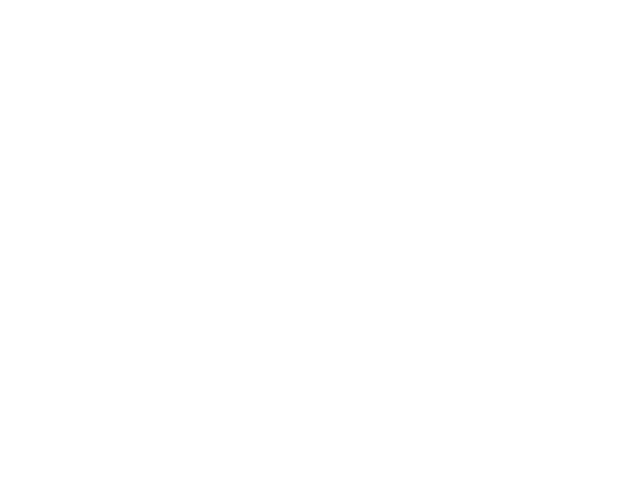
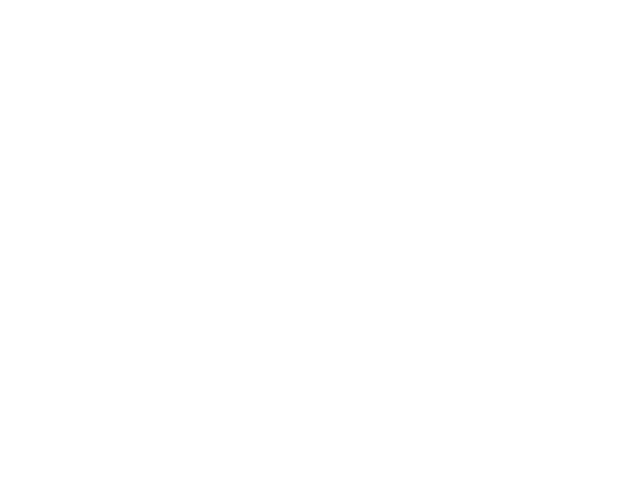

In [255]:
dashboard()

In [187]:
def diffseqs(seq1,seq2):
    """Diff two sequences"""

    c=0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            c+=1
    return c

def diffseqs2(seq1, seq2):
    """Diff two sequences"""

    return sum(a != b for a, b in zip(seq1, seq2))


s1='ATTGCGGGAGAGGTTTTTAAAAATTCTGCGGGATACGTTTTTAAAAAGGAGAGGTTTTTAAAAATTCTGCGGGATACGTTTTTAAAAA'
s2='ATTTCGGGCGAGTTTCTTAATAATAATGCGGGATAAGTTATTTAATAGGAGAGGTTTTTAAAAATTCTGCGGGATACGTTTTTAAAAA'
%timeit diffseqs(s1,s2)

3.32 µs ± 17.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## run model and extract relevant metrics for regression model testing

In [233]:
reload(models)
model=models.FarmPathogenModel(60,1000,5,graph_seed=5,seq_length=100,allow_moves=False)
for i in range(10000):
    model.step()
print (model)

model with 60 farms, 5 setts and 1040 animals
CC rate:0.01 BC rate:0.001


In [234]:
reload(utils)
model.make_phylogeny(removed=True,redundant=False)
aln = AlignIO.read('temp.fasta','fasta')
snpdist = utils.snp_dist_matrix(aln)
snpdist.to_csv('snpdist.csv')
print (len(snpdist))

3041


In [235]:
meta = model.get_animal_data(removed=True,infected=True)
cl = model.get_clades(removed=True, redundant=False)
meta = meta.merge(cl,left_on='id',right_on='SequenceName')
meta = meta[meta.id.isin(snpdist.index)]
meta.to_csv('meta.csv',index=False)

In [236]:
reload(utils)
x=meta.set_index('SequenceName')
x.index = x.index.map(str)
#print (x)
col='snp12'
canvas = utils.draw_tree('tree.newick',x,col,tip_labels=False,width=500)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="600.0px" viewBox="0 0 500.0 600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2cf6e6fa87b24545a90a8d65793f4f25"> <path d="M

In [237]:
#model=models.FarmPathogenModel(20,400,5)
gdf = model.get_geodataframe(removed=True)
gdf = gdf[gdf.id.isin(snpdist.index)]
gdf.to_file('cent.shp.zip')
gdf=gdf.merge(cl,left_on='id',right_on='SequenceName')
print (len(gdf))

3041


<AxesSubplot: >

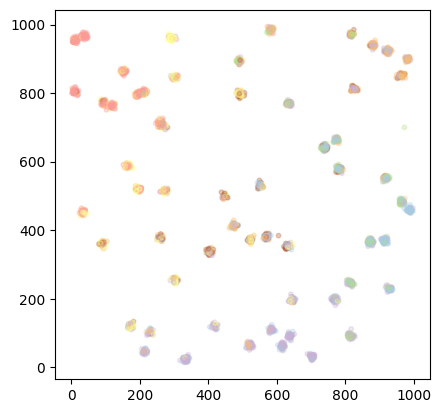

In [238]:
gdf['geometry'] = gdf.apply(lambda x: utils.jitter_points(x,5),1)
gdf.plot(column='strain',s=10,alpha=0.3,cmap='Paired')#,legend=True)

In [ ]:
meta#.inf_start.hist()
#fig,ax=plt.subplots(1,1,figsize=(20,10))
#utils.plot_grid(model,ax=ax,pos=model.pos,colorby='strain',ns='num_infected')

## epi metrics regression testing

In [222]:
from btbabm import epi_regression

3041 samples
4625361
4625361
4625361
4625361
filtered samples
716909 716909


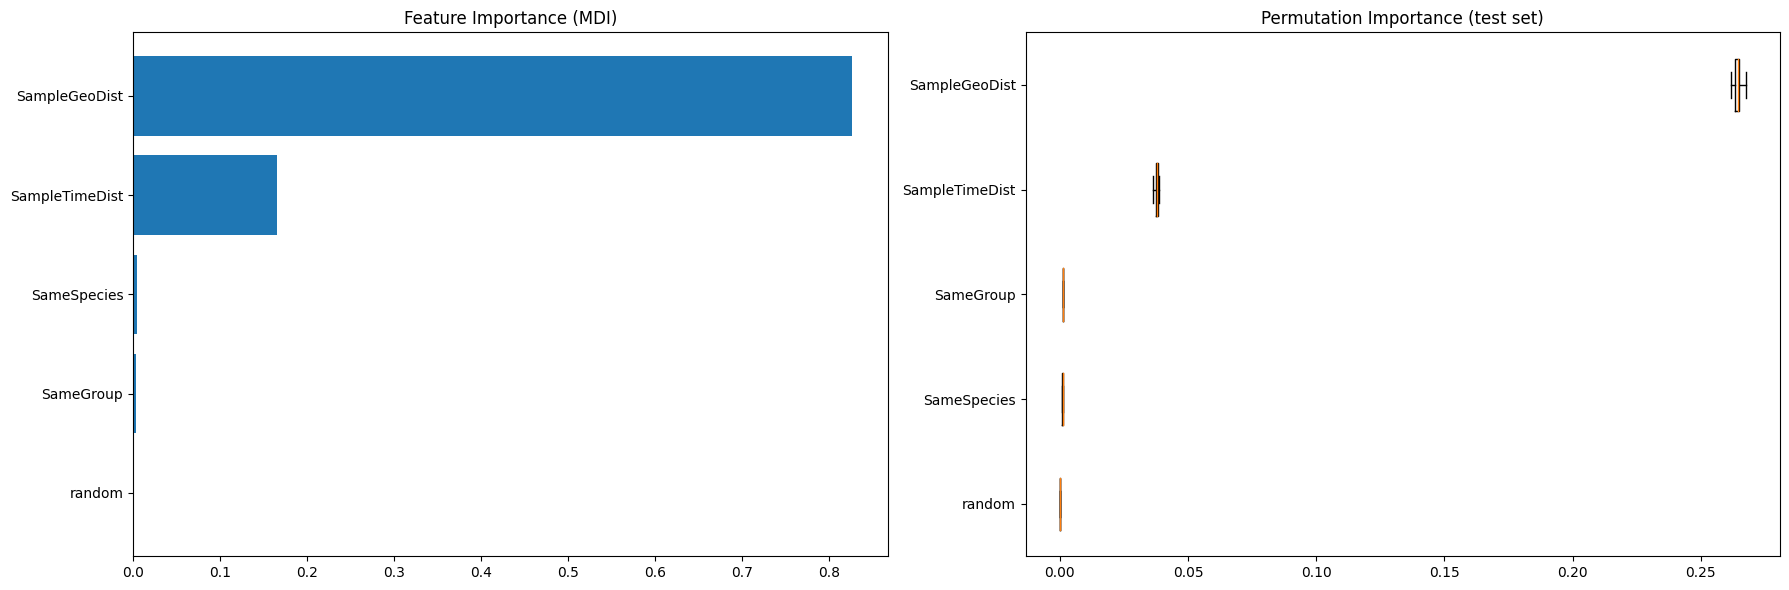

In [239]:
reload(epi_regression)
X,y=epi_regression.test(snp_cutoff=12)

<AxesSubplot: xlabel='y', ylabel='SampleTimeDist'>

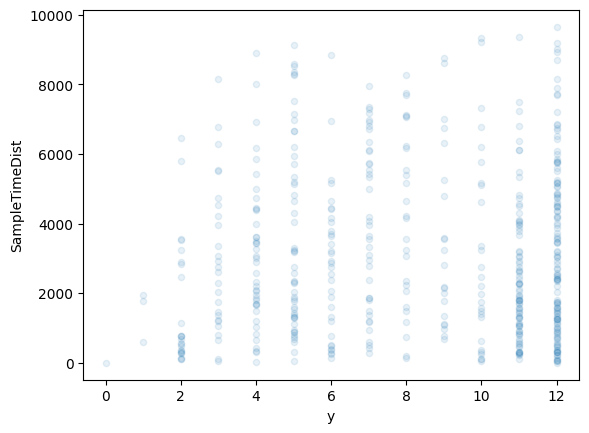

In [240]:
X['y'] = y
df=X.sample(500)
df.plot('y','SampleTimeDist',alpha=0.1,kind='scatter')

## moves data - large movement history simulation

In [ ]:
reload(models)
model=models.FarmPathogenModel(500,50000,5,mean_stay_time=100,graph_seed=5,seq_length=100,allow_moves=True)
print (model)

In [ ]:
for i in range(20):
    model.step()

In [ ]:
movedata = model.get_moves(removed=True)
movedata.id.value_counts().hist()
movedata

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
utils.plot_grid(model,ax=ax,pos=model.pos,colorby='strain',ns='num_infected')